# Marathon Predictor

### Import packages ###

In [1]:
import pandas as pd
import numpy as np
import math
import time
import os
import re

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib.ticker import FuncFormatter
from matplotlib.offsetbox import AnchoredText

from sklearn.model_selection import train_test_split

pd.options.mode.chained_assignment = None  # default='warn'

%matplotlib widget

### Load full data ###

In [2]:
# Load full data
directory = 'full_df_csvs'
newest_full_df = [file for file in sorted(os.listdir(directory)) if file.endswith('.csv')][-1]
full_df = pd.read_csv(os.path.join(directory, newest_full_df))

# Update data types
full_df['Date'] = pd.to_datetime(full_df['Date'])
time_cols = ['Male Win','Female Win','Average Time','Time STD']
full_df[time_cols] = (full_df[time_cols].apply(pd.to_timedelta))

# full_df.dtypes

In [3]:
# Feature Variables
X = full_df[['Event Name', 'City', 'State', 
            'Date', 
            'Finishers', 'Males', 'Females', 'Percent Female',
            'Elev Gain', 'Elev Loss', 'Elev Max', 'Elev Min', 
            'STATION', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 
            'TEMP', 'MAX', 'MIN', 'PRCP', 'DEWP', 'WDSP', 'RELHUM']]
# Dates will be in days (float) since Jan 1, 2000
X['Date'] = (pd.to_datetime(X['Date']) - pd.to_datetime('2000-01-01'))/np.timedelta64(1, 'D')

# Target Variables: Run times will be in seconds (float)
y_average = full_df['Average Time'] / np.timedelta64(1, 's')
y_male = full_df['Male Win'] / np.timedelta64(1, 's')
y_female = full_df['Female Win'] / np.timedelta64(1, 's')

### Exploratory Data Visualization ###

In [4]:
# Create a formatter for reading plot axes as h:mm or h:mm:ss
from matplotlib.ticker import FuncFormatter

def format_func(x, pos):
    hours = int(x//3600)
    minutes = int((x%3600)//60)
    seconds = int(x%60)

    return "{:d}:{:02d}".format(hours, minutes)
    # return "{:d}:{:02d}:{:02d}".format(hours, minutes, seconds)

formatter = FuncFormatter(format_func)

In [5]:
# see available built-in styles.
# plt.style.available

In [8]:
plt.style.use('seaborn-colorblind')

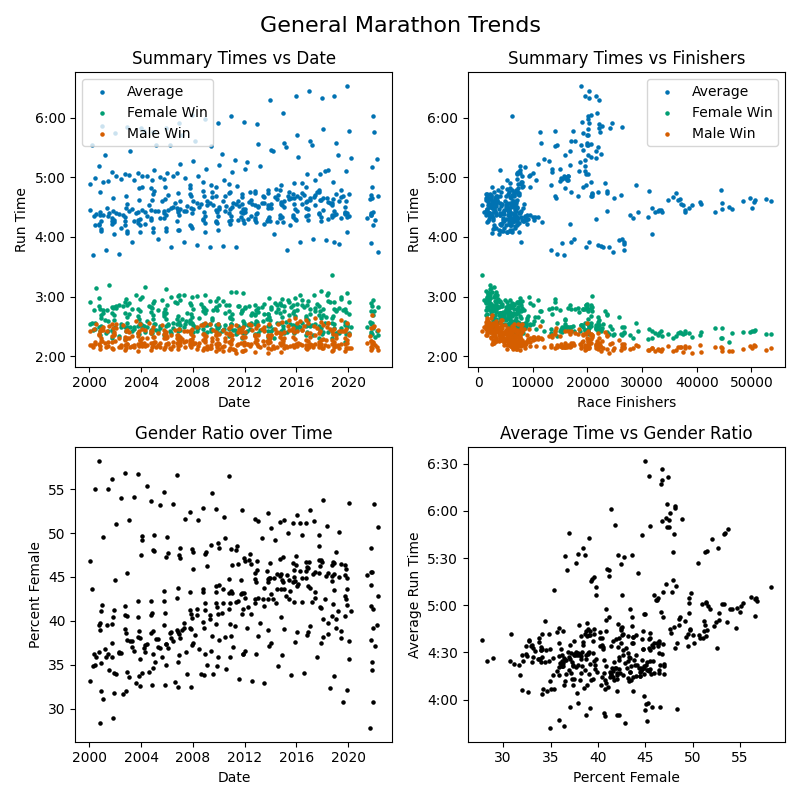

In [19]:
fig, axs = plt.subplots(2,2,figsize=(8,8))
((ax1,ax2),(ax3,ax4)) = axs

ax1.scatter(full_df['Date'],y_average, s=5, label='Average')
ax1.scatter(full_df['Date'],y_female, s=5, label='Female Win')
ax1.scatter(full_df['Date'],y_male, s=5, label='Male Win')
ax1.set_xlabel('Date')
ax1.set_ylabel('Run Time')
ax1.set_title('Summary Times vs Date')

ax2.scatter(full_df['Finishers'],y_average, s=5, label='Average')
ax2.scatter(full_df['Finishers'],y_female, s=5, label='Female Win')
ax2.scatter(full_df['Finishers'],y_male, s=5, label='Male Win')
ax2.set_xlabel('Race Finishers')
ax2.set_ylabel('Run Time')
ax2.set_title('Summary Times vs Finishers')

ax3.scatter(full_df['Date'],full_df['Percent Female'], color='k', s=5, label='_none')
ax3.set_xlabel('Date')
ax3.set_ylabel('Percent Female')
ax3.set_title('Gender Ratio over Time')

ax4.scatter(full_df['Percent Female'],y_average, color='k', s=5, label='Average')
ax4.set_xlabel('Percent Female')
ax4.set_ylabel('Average Run Time')
ax4.set_title('Average Time vs Gender Ratio')

# Set tick labels and legends
for ax in [ax1,ax2]:
    ax.yaxis.set_major_locator(mticker.MultipleLocator(base=3600))
    ax.yaxis.set_major_formatter(formatter)
    ax.legend()
ax4.yaxis.set_major_locator(mticker.MultipleLocator(base=1800))
ax4.yaxis.set_major_formatter(formatter)

fig.suptitle('General Marathon Trends', fontsize=16)
# axs[0,0].xaxis.set_tick_params(rotation=45)
fig.tight_layout()

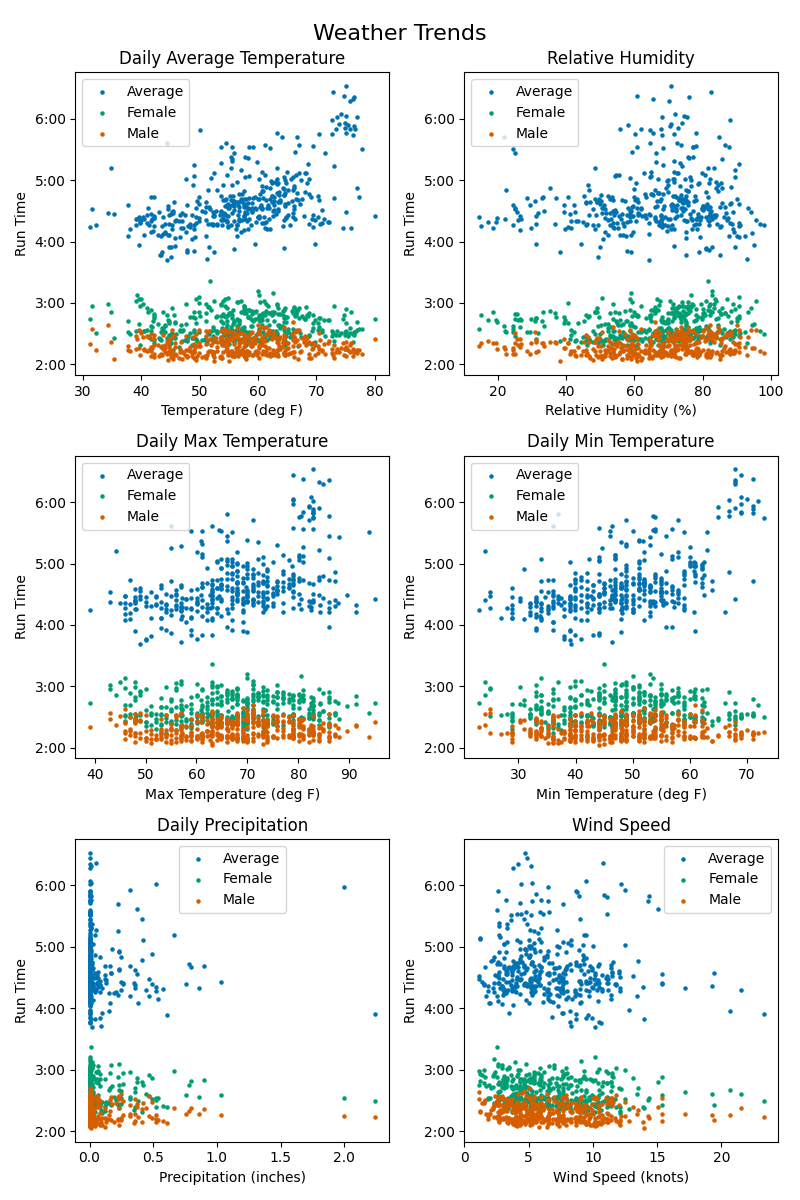

In [17]:
# Plot weather data
# 'TEMP', 'RELHUM',
# 'MAX', 'MIN',
# 'PRCP', 'WDSP'
fig, axs = plt.subplots(3,2,figsize=(8,12))
((ax1,ax2),(ax3,ax4),(ax5,ax6)) = axs

ax1.scatter(full_df['TEMP'],y_average, s=5, label='Average')
ax1.scatter(full_df['TEMP'],y_female, s=5, label='Female')
ax1.scatter(full_df['TEMP'],y_male, s=5, label='Male')
ax1.set_xlabel('Temperature (deg F)')
ax1.set_ylabel('Run Time')
ax1.set_title('Daily Average Temperature')

ax2.scatter(full_df['RELHUM'],y_average, s=5, label='Average')
ax2.scatter(full_df['RELHUM'],y_female, s=5, label='Female')
ax2.scatter(full_df['RELHUM'],y_male, s=5, label='Male')
ax2.set_xlabel('Relative Humidity (%)')
ax2.set_ylabel('Run Time')
ax2.set_title('Relative Humidity')

ax3.scatter(full_df['MAX'],y_average, s=5, label='Average')
ax3.scatter(full_df['MAX'],y_female, s=5, label='Female')
ax3.scatter(full_df['MAX'],y_male, s=5, label='Male')
ax3.set_xlabel('Max Temperature (deg F)')
ax3.set_ylabel('Run Time')
ax3.set_title('Daily Max Temperature')

ax4.scatter(full_df['MIN'],y_average, s=5, label='Average')
ax4.scatter(full_df['MIN'],y_female, s=5, label='Female')
ax4.scatter(full_df['MIN'],y_male, s=5, label='Male')
ax4.set_xlabel('Min Temperature (deg F)')
ax4.set_ylabel('Run Time')
ax4.set_title('Daily Min Temperature')

ax5.scatter(full_df['PRCP'],y_average, s=5, label='Average')
ax5.scatter(full_df['PRCP'],y_female, s=5, label='Female')
ax5.scatter(full_df['PRCP'],y_male, s=5, label='Male')
ax5.set_xlabel('Precipitation (inches)')
ax5.set_ylabel('Run Time')
ax5.set_title('Daily Precipitation')

ax6.scatter(full_df['WDSP'],y_average, s=5, label='Average')
ax6.scatter(full_df['WDSP'],y_female, s=5, label='Female')
ax6.scatter(full_df['WDSP'],y_male, s=5, label='Male')
ax6.set_xlabel('Wind Speed (knots)')
ax6.set_ylabel('Run Time')
ax6.set_title('Wind Speed')

# Set tick labels and legends
for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    ax.yaxis.set_major_locator(mticker.MultipleLocator(base=3600))
    ax.yaxis.set_major_formatter(formatter)
    ax.legend()

fig.suptitle('Weather Trends', fontsize=16)

fig.tight_layout()

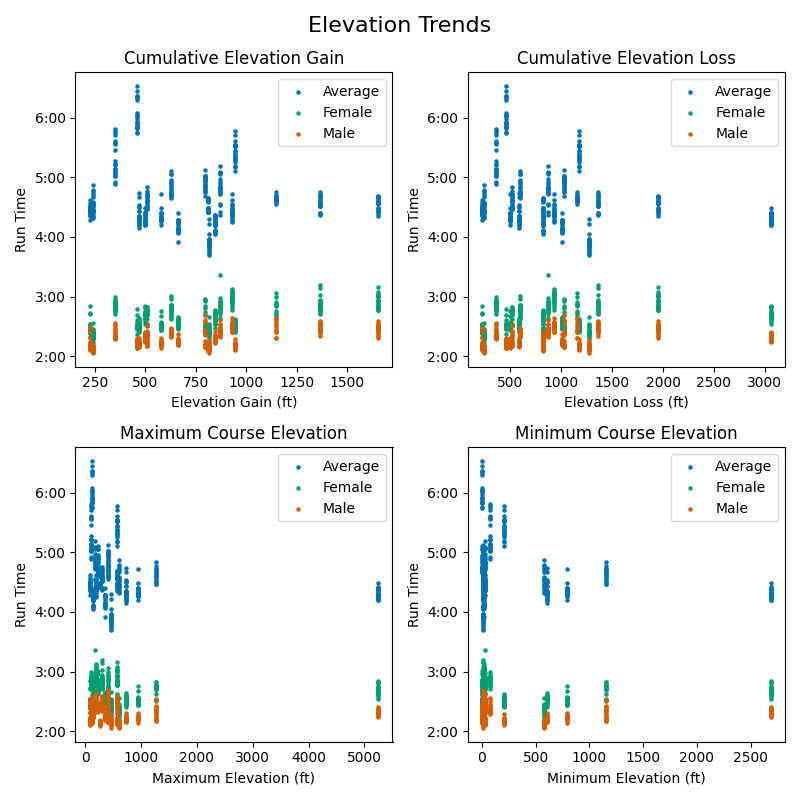

In [20]:
# Plot elevation data
# 'Elev Gain', 'Elev Loss',
# 'Elev Max', 'Elev Min', 
fig, axs = plt.subplots(2,2,figsize=(8,8))
((ax1,ax2),(ax3,ax4)) = axs

ax1.scatter(full_df['Elev Gain'],y_average, s=5, label='Average')
ax1.scatter(full_df['Elev Gain'],y_female, s=5, label='Female')
ax1.scatter(full_df['Elev Gain'],y_male, s=5, label='Male')
ax1.set_xlabel('Elevation Gain (ft)')
ax1.set_ylabel('Run Time')
ax1.set_title('Cumulative Elevation Gain')

ax2.scatter(full_df['Elev Loss'],y_average, s=5, label='Average')
ax2.scatter(full_df['Elev Loss'],y_female, s=5, label='Female')
ax2.scatter(full_df['Elev Loss'],y_male, s=5, label='Male')
ax2.set_xlabel('Elevation Loss (ft)')
ax2.set_ylabel('Run Time')
ax2.set_title('Cumulative Elevation Loss')

ax3.scatter(full_df['Elev Max'],y_average, s=5, label='Average')
ax3.scatter(full_df['Elev Max'],y_female, s=5, label='Female')
ax3.scatter(full_df['Elev Max'],y_male, s=5, label='Male')
ax3.set_xlabel('Maximum Elevation (ft)')
ax3.set_ylabel('Run Time')
ax3.set_title('Maximum Course Elevation')

ax4.scatter(full_df['Elev Min'],y_average, s=5, label='Average')
ax4.scatter(full_df['Elev Min'],y_female, s=5, label='Female')
ax4.scatter(full_df['Elev Min'],y_male, s=5, label='Male')
ax4.set_xlabel('Minimum Elevation (ft)')
ax4.set_ylabel('Run Time')
ax4.set_title('Minimum Course Elevation')

# Set tick labels and legends
for ax in [ax1,ax2,ax3,ax4]:
    ax.yaxis.set_major_locator(mticker.MultipleLocator(base=3600))
    ax.yaxis.set_major_formatter(formatter)
    ax.legend()

fig.suptitle('Elevation Trends', fontsize=16)

fig.tight_layout()

### Define feature and target variables

In [21]:
# Load full data
directory = 'full_df_csvs'
newest_full_df = [file for file in sorted(os.listdir(directory)) if file.endswith('.csv')][-1]
full_df = pd.read_csv(os.path.join(directory, newest_full_df))

# Update data types
full_df['Date'] = pd.to_datetime(full_df['Date'])
time_cols = ['Male Win','Female Win','Average Time','Time STD']
full_df[time_cols] = (full_df[time_cols].apply(pd.to_timedelta))

# full_df.dtypes

#### Option A: Train-test split uses mix of all dates

In [76]:
# Train-test split is random
from sklearn.model_selection import train_test_split

# Feature Variables
X = full_df[[#'Event Name', 'City', 'State', 
            'Date', 
            'Finishers', 'Males', 'Females', 'Percent Female',
            'Elev Gain', 'Elev Loss', 'Elev Max', 'Elev Min', 
            'STATION', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 
            'TEMP', 'MAX', 'MIN', 'PRCP', 'DEWP', 'WDSP', 'RELHUM']]
# Dates will be in days (float) since Jan 1, 2000
X['Date'] = (pd.to_datetime(X['Date']) - pd.to_datetime('2000-01-01'))/np.timedelta64(1, 'D')

# Target Variables: Run times will be in seconds (float)
y_average = full_df['Average Time'] / np.timedelta64(1, 's')
y_male = full_df['Male Win'] / np.timedelta64(1, 's')
y_female = full_df['Female Win'] / np.timedelta64(1, 's')

X_ave_train, X_ave_test, y_ave_train, y_ave_test = train_test_split(X, y_average, random_state=0)
X_f_train, X_f_test, y_f_train, y_f_test = train_test_split(X, y_female, random_state=0)
X_m_train, X_m_test, y_m_train, y_m_test = train_test_split(X, y_male, random_state=0)

# X.dtypes
# y_average.dtypes

In [77]:
print(f'Total events: {len(X)}')
print(f'Train events: {len(X_ave_train)}')
print(f'Test events: {len(X_ave_test)}')
print(f'Split Fraction: {len(X_ave_test)/len(X)}')

Total events: 406
Train events: 304
Test events: 102
Split Fraction: 0.2512315270935961


#### Option B: Train on 2000-2015 and Test on 2016-2022

In [37]:
# Train-test split is by Date
train_df = full_df[full_df['Date'] < pd.to_datetime('2016-01-01')].sort_values('Date')
test_df = full_df[full_df['Date'] >= pd.to_datetime('2016-01-01')].sort_values('Date')

# Dates will be in days (float) since Jan 1, 2000
train_df['Date'] = (pd.to_datetime(train_df['Date']) - pd.to_datetime('2000-01-01'))/np.timedelta64(1, 'D')
test_df['Date'] = (pd.to_datetime(test_df['Date']) - pd.to_datetime('2000-01-01'))/np.timedelta64(1, 'D')

# Feature Variables
features = [#'Event Name', 'City', 'State', 
            'Date', 
            'Finishers', 'Males', 'Females', 'Percent Female',
            'Elev Gain', 'Elev Loss', 'Elev Max', 'Elev Min', 
            'STATION', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 
            'TEMP', 'MAX', 'MIN', 'PRCP', 'DEWP', 'WDSP', 'RELHUM']

X_ave_train = train_df[features]
X_f_train = X_ave_train
X_m_train = X_ave_train

X_ave_test = test_df[features]
X_f_test = X_ave_test
X_m_test = X_ave_test

# Target Variables: Run times will be in seconds (float)
y_ave_train = train_df['Average Time'] / np.timedelta64(1, 's')
y_m_train = train_df['Male Win'] / np.timedelta64(1, 's')
y_f_train = train_df['Female Win'] / np.timedelta64(1, 's')

y_ave_test = test_df['Average Time'] / np.timedelta64(1, 's')
y_m_test = test_df['Male Win'] / np.timedelta64(1, 's')
y_f_test = test_df['Female Win'] / np.timedelta64(1, 's')

In [38]:
print(f'Total events: {len(X_ave_test)+len(X_ave_train)}')
print(f'Train events: {len(X_ave_train)}')
print(f'Test events: {len(X_ave_test)}')
print(f'Split Fraction: {len(X_ave_test)/(len(X_ave_test)+len(X_ave_train))}')

# full_df
# test_df
# y_ave_train

Total events: 406
Train events: 304
Test events: 102
Split Fraction: 0.2512315270935961


### Linear, Ridge, and Lasso Regression: Default Parameters ###

In [78]:
# Scale the input features based on medians and inter-quartile ranges
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_ave_train_scaled = scaler.fit_transform(X_ave_train)
# we must apply the scaling to the test set that we computed for the training set
X_ave_test_scaled = scaler.transform(X_ave_test)

In [79]:
# Linear Regression with default parameters
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# Create df to store scores and model coefficients
linreg_df = pd.DataFrame(columns=['R2 train','R2 test','Intercept']+list(X_ave_train.columns))

# Linear Regression
linreg_ave = LinearRegression().fit(X_ave_train_scaled, y_ave_train)
linreg_df.loc['Linear Ave','R2 train'] = linreg_ave.score(X_ave_train_scaled, y_ave_train)
linreg_df.loc['Linear Ave','R2 test'] = linreg_ave.score(X_ave_test_scaled, y_ave_test)
linreg_df.loc['Linear Ave','Intercept'] = linreg_ave.intercept_
linreg_df.loc['Linear Ave'].iloc[3:] = linreg_ave.coef_

# Ridge Regression
ridge_ave = Ridge(random_state=0).fit(X_ave_train_scaled, y_ave_train)
linreg_df.loc['Ridge Ave','R2 train'] = ridge_ave.score(X_ave_train_scaled, y_ave_train)
linreg_df.loc['Ridge Ave','R2 test'] = ridge_ave.score(X_ave_test_scaled, y_ave_test)
linreg_df.loc['Ridge Ave','Intercept'] = ridge_ave.intercept_
linreg_df.loc['Ridge Ave'].iloc[3:] = ridge_ave.coef_

# Lasso Regression
lasso_ave = Lasso(random_state=0, max_iter=5000).fit(X_ave_train_scaled, y_ave_train)
linreg_df.loc['Lasso Ave','R2 train'] = lasso_ave.score(X_ave_train_scaled, y_ave_train)
linreg_df.loc['Lasso Ave','R2 test'] = lasso_ave.score(X_ave_test_scaled, y_ave_test)
linreg_df.loc['Lasso Ave','Intercept'] = lasso_ave.intercept_
linreg_df.loc['Lasso Ave'].iloc[3:] = lasso_ave.coef_

# print(ridge_ave.get_params().keys())
linreg_df

,R2 train,R2 test,Intercept,Date,Finishers,Males,Females,Percent Female,Elev Gain,Elev Loss,...,LATITUDE,LONGITUDE,ELEVATION,TEMP,MAX,MIN,PRCP,DEWP,WDSP,RELHUM
Linear Ave,0.772337,0.761092,19094.269342,88.006662,-144555.196845,77624.249756,61673.562372,565.512121,1401.863197,-2767.898019,...,-1066.624299,-1152.320772,360.59698,925.909626,-248.036982,-402.048348,2.53482,399.717028,-269.856776,-0.341898
Ridge Ave,0.765534,0.757342,16324.050337,95.433935,203.87246,501.350129,-123.809663,539.503817,870.639259,-1558.287201,...,-1017.309742,-1039.989447,223.018949,562.502209,-163.841316,-177.49903,2.598602,551.272453,-294.191598,-142.865214
Lasso Ave,0.770013,0.761216,16419.60121,92.831412,0.0,589.637943,-0.0,554.9905,1261.776316,-2424.87316,...,-1042.686388,-1103.996553,323.02778,718.423244,-152.80259,-238.3228,2.504887,355.838251,-275.982601,-6.747616


### Ridge and Lasso Regression with Grid Search Cross-validation ###

In [80]:
# Ridge Regression: Grid Search with K-fold cross-validator
from sklearn.model_selection import GridSearchCV
# Training split uses K-fold cross validation
from sklearn.model_selection import KFold

shuffle_cv = KFold(n_splits=5, shuffle=True, random_state=0)
grid_values = {'alpha': [0.01, 0.1, 1, 10]}

ridge_shuffle_ave = Ridge(random_state=0)
grid_ridge_shuffle_ave = GridSearchCV(ridge_shuffle_ave, param_grid = grid_values, cv=shuffle_cv)
grid_ridge_shuffle_ave.fit(X_ave_train_scaled, y_ave_train)

print(f'Best Paramters (squared error): {grid_ridge_shuffle_ave.best_params_}')
print(f'Best Score (R^2): {grid_ridge_shuffle_ave.best_score_}')
print(f'Test Set Score (R^2): {grid_ridge_shuffle_ave.score(X_ave_test_scaled, y_ave_test)}')

Best Paramters (squared error): {'alpha': 1}
Best Score (R^2): 0.7231954093735549
Test Set Score (R^2): 0.7573419231967511


In [81]:
# Lasso Regression: Grid Search with K-fold cross-validator
from sklearn.model_selection import GridSearchCV
# Training split uses K-fold cross validation
from sklearn.model_selection import KFold

shuffle_cv = KFold(n_splits=5, shuffle=True, random_state=0)
grid_values = {'alpha': [0.01, 0.1, 1, 10]}

lasso_shuffle_ave = Lasso(random_state=0, max_iter=5000)
grid_lasso_shuffle_ave = GridSearchCV(lasso_shuffle_ave, param_grid = grid_values, cv=shuffle_cv)
grid_lasso_shuffle_ave.fit(X_ave_train_scaled, y_ave_train)

print(f'Best Paramters (squared error): {grid_lasso_shuffle_ave.best_params_}')
print(f'Best Score (R^2): {grid_lasso_shuffle_ave.best_score_}')
print(f'Test Set Score (R^2): {grid_lasso_shuffle_ave.score(X_ave_test_scaled, y_ave_test)}')

Best Paramters (squared error): {'alpha': 1}
Best Score (R^2): 0.7249770553291823
Test Set Score (R^2): 0.7612164466638909


/Users/michael/Documents/PythonCoding/environments/datasci5/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.269e+07, tolerance: 7.778e+04
  model = cd_fast.enet_coordinate_descent(
/Users/michael/Documents/PythonCoding/environments/datasci5/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.014e+07, tolerance: 7.835e+04
  model = cd_fast.enet_coordinate_descent(
/Users/michael/Documents/PythonCoding/environments/datasci5/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to inc

In [82]:
# View Summary Table of Linear Reg Coefficients
linreg_df.loc['Ridge Ave CV','R2 train'] = grid_ridge_shuffle_ave.score(X_ave_train_scaled, y_ave_train)
linreg_df.loc['Ridge Ave CV','R2 test'] = grid_ridge_shuffle_ave.score(X_ave_test_scaled, y_ave_test)
linreg_df.loc['Ridge Ave CV','Intercept'] = grid_ridge_shuffle_ave.best_estimator_.intercept_
linreg_df.loc['Ridge Ave CV'].iloc[3:] = grid_ridge_shuffle_ave.best_estimator_.coef_

linreg_df.loc['Lasso Ave CV','R2 train'] = grid_lasso_shuffle_ave.score(X_ave_train_scaled, y_ave_train)
linreg_df.loc['Lasso Ave CV','R2 test'] = grid_lasso_shuffle_ave.score(X_ave_test_scaled, y_ave_test)
linreg_df.loc['Lasso Ave CV','Intercept'] = grid_lasso_shuffle_ave.best_estimator_.intercept_
linreg_df.loc['Lasso Ave CV'].iloc[3:] = grid_lasso_shuffle_ave.best_estimator_.coef_

linreg_df

,R2 train,R2 test,Intercept,Date,Finishers,Males,Females,Percent Female,Elev Gain,Elev Loss,...,LATITUDE,LONGITUDE,ELEVATION,TEMP,MAX,MIN,PRCP,DEWP,WDSP,RELHUM
Linear Ave,0.772337,0.761092,19094.269342,88.006662,-144555.196845,77624.249756,61673.562372,565.512121,1401.863197,-2767.898019,...,-1066.624299,-1152.320772,360.59698,925.909626,-248.036982,-402.048348,2.53482,399.717028,-269.856776,-0.341898
Ridge Ave,0.765534,0.757342,16324.050337,95.433935,203.87246,501.350129,-123.809663,539.503817,870.639259,-1558.287201,...,-1017.309742,-1039.989447,223.018949,562.502209,-163.841316,-177.49903,2.598602,551.272453,-294.191598,-142.865214
Lasso Ave,0.770013,0.761216,16419.60121,92.831412,0.0,589.637943,-0.0,554.9905,1261.776316,-2424.87316,...,-1042.686388,-1103.996553,323.02778,718.423244,-152.80259,-238.3228,2.504887,355.838251,-275.982601,-6.747616
Ridge Ave CV,0.765534,0.757342,16324.050337,95.433935,203.87246,501.350129,-123.809663,539.503817,870.639259,-1558.287201,...,-1017.309742,-1039.989447,223.018949,562.502209,-163.841316,-177.49903,2.598602,551.272453,-294.191598,-142.865214
Lasso Ave CV,0.770013,0.761216,16419.60121,92.831412,0.0,589.637943,-0.0,554.9905,1261.776316,-2424.87316,...,-1042.686388,-1103.996553,323.02778,718.423244,-152.80259,-238.3228,2.504887,355.838251,-275.982601,-6.747616


In [85]:
# View Groupings of Lasso Reg Coefficients
pos_coef = [coef for coef in zip(grid_lasso_shuffle_ave.best_estimator_.coef_,list(X_ave_train.columns)) if coef[0]>=100]
neg_coef = [coef for coef in zip(grid_lasso_shuffle_ave.best_estimator_.coef_,list(X_ave_train.columns)) if coef[0]<=-100]
zero_coef = [coef for coef in zip(grid_lasso_shuffle_ave.best_estimator_.coef_,list(X_ave_train.columns)) if abs(coef[0])<100]

print('\nBeneficial Factors:')
for i, j in sorted(neg_coef):
    print(f'   {j} {i:.0f}')
print('\nDetrimental Factors:')
for i, j in sorted(pos_coef, reverse=True):
    print(f'   {j} {i:.0f}')
print('\nLow-Impact Factors:')
for i, j in sorted(zero_coef):
    print(f'   {j} {i:.0f}')


Beneficial Factors:
   Elev Loss -2425
   Elev Min -2136
   LONGITUDE -1104
   LATITUDE -1043
   WDSP -276
   MIN -238
   MAX -153

Detrimental Factors:
   Elev Max 1350
   Elev Gain 1262
   TEMP 718
   Males 590
   Percent Female 555
   DEWP 356
   ELEVATION 323

Low-Impact Factors:
   RELHUM -7
   STATION -3
   Females -0
   Finishers 0
   PRCP 3
   Date 93


### Random Forest and Gradient Boosted Decision Tree: Default Parameters ###

In [26]:
# Random Forest Regressors: Default parameters
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate

print('Random Forest Regressors')

# Average Times
print('\n   Average Run Times')
rf_ave = RandomForestRegressor(max_depth=None, random_state=0)
rf_ave.fit(X_ave_train, y_ave_train)
print(f'Train Score: {rf_ave.score(X_ave_train, y_ave_train)}')
print(f'Test Score: {rf_ave.score(X_ave_test, y_ave_test)}')

# Female Wins
print('\n   Female Win Times')
rf_female = RandomForestRegressor(max_depth=None, random_state=0)
rf_female.fit(X_f_train, y_f_train)
print(f'Train Score: {rf_female.score(X_f_train, y_f_train)}')
print(f'Test Score: {rf_female.score(X_f_test, y_f_test)}')

# Male Wins
print('\n   Male Win Times')
rf_male = RandomForestRegressor(max_depth=None, random_state=0)
rf_male.fit(X_m_train, y_m_train)
print(f'Train Score: {rf_male.score(X_m_train, y_m_train)}')
print(f'Test Score: {rf_male.score(X_m_test, y_m_test)}')

# print(regr.predict([[0, 0, 0, 0]]))

Random Forest Regressors

   Average Run Times
Train Score: 0.9950461265261321
Test Score: 0.8829037493416145

   Female Win Times
Train Score: 0.9748012400958829
Test Score: 0.7060348888283718

   Male Win Times
Train Score: 0.9764619108264133
Test Score: 0.780094416964991


In [27]:
# Random Forest Regressors

#    Average Run Times
# Train Score: 0.9950461265261321
# Test Score: 0.8829037493416145

#    Female Win Times
# Train Score: 0.9748012400958829
# Test Score: 0.7060348888283718

#    Male Win Times
# Train Score: 0.9764619108264133
# Test Score: 0.780094416964991

In [28]:
# Gradient Boosting Tree Ensembles: Default parameters
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate

print('Gradient Boosting Regressors')

# Average Times
print('\n   Average Run Times')
gb_ave = GradientBoostingRegressor(max_depth=3, random_state=0)
gb_ave.fit(X_ave_train, y_ave_train)
print(f'Train Score: {gb_ave.score(X_ave_train, y_ave_train)}')
print(f'Test Score: {gb_ave.score(X_ave_test, y_ave_test)}')

# Female Wins
print('\n   Female Win Times')
gb_female = GradientBoostingRegressor(max_depth=3, random_state=0)
gb_female.fit(X_f_train, y_f_train)
print(f'Train Score: {gb_female.score(X_f_train, y_f_train)}')
print(f'Test Score: {gb_female.score(X_f_test, y_f_test)}')

# Male Wins
print('\n   Male Win Times')
gb_male = GradientBoostingRegressor(max_depth=3, random_state=0)
gb_male.fit(X_m_train, y_m_train)
print(f'Train Score: {gb_male.score(X_m_train, y_m_train)}')
print(f'Test Score: {gb_male.score(X_m_test, y_m_test)}')

# reg.predict(X_test[1:2])

Gradient Boosting Regressors

   Average Run Times
Train Score: 0.993531533363386
Test Score: 0.8689688733102867

   Female Win Times
Train Score: 0.9711857846763055
Test Score: 0.618034174759329

   Male Win Times
Train Score: 0.9650934605583189
Test Score: 0.7489883911130311


In [29]:
# Gradient Boosting Regressors

#    Average Run Times
# Train Score: 0.993531533363386
# Test Score: 0.8689688733102867

#    Female Win Times
# Train Score: 0.9711857846763055
# Test Score: 0.618034174759329

#    Male Win Times
# Train Score: 0.9650934605583189
# Test Score: 0.7489883911130311

### Tree Ensembles with Cross-validation ###

In [30]:
# Gradient Boosting Tree Ensembles: Grid Search with K-fold cross-validator
from sklearn.model_selection import GridSearchCV
# Training split uses K-fold cross validation
from sklearn.model_selection import KFold

shuffle_cv = KFold(n_splits=5, shuffle=True, random_state=0)
grid_values = {'max_depth': [1, 2, 3, 4],
               'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2],
               'n_estimators': [50, 100, 150, 200, 250]}

gb_shuffle_ave = GradientBoostingRegressor(random_state=0)
grid_gb_shuffle_ave = GridSearchCV(gb_shuffle_ave, param_grid = grid_values, cv=shuffle_cv)
grid_gb_shuffle_ave.fit(X_ave_train, y_ave_train)

print(f'Best Paramters (squared error): {grid_gb_shuffle_ave.best_params_}')
print(f'Best Score (R^2): {grid_gb_shuffle_ave.best_score_}')
print(f'Test Set Score (R^2): {grid_gb_shuffle_ave.score(X_ave_test, y_ave_test)}')

Best Paramters (squared error): {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 250}
Best Score (R^2): 0.9579724218584735
Test Set Score (R^2): 0.8746660975538072


In [31]:
# 2016-2022 Test (102/406), With shuffle=True, random_state=0:__
# Best Paramters (squared error): {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 250}
# Best Score (R^2): 0.9579724218584735
# Test Set Score (R^2): 0.8746660975538072

# Sample all years Test, With shuffle=True, random_state=0:
# Best Paramters (squared error): {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 250}
# Best Score (R^2): 0.936252871209456
# Test Set Score (R^2): 0.9337701946985129

In [32]:
# Random Forest Tree Ensembles: Grid Search with K-fold cross-validator
from sklearn.model_selection import GridSearchCV
# Training split uses K-fold cross validation
from sklearn.model_selection import KFold

shuffle_cv = KFold(n_splits=5, shuffle=True, random_state=0)
grid_values = {'max_features': [0.2, 0.25, 0.3, 0.35, 0.4, 0.6, 1.0],
               'max_samples': [0.6, 0.8, 1.0]}

rf_shuffle_ave = RandomForestRegressor(n_estimators=250, random_state=0)
grid_rf_shuffle_ave = GridSearchCV(rf_shuffle_ave, param_grid = grid_values, cv=shuffle_cv)
grid_rf_shuffle_ave.fit(X_ave_train, y_ave_train)

print(f'Best Paramters (squared error): {grid_rf_shuffle_ave.best_params_}')
print(f'Best Score (R^2): {grid_rf_shuffle_ave.best_score_}')
print(f'Test Set Score (R^2): {grid_rf_shuffle_ave.score(X_ave_test, y_ave_test)}')

Best Paramters (squared error): {'max_features': 0.3, 'max_samples': 1.0}
Best Score (R^2): 0.9626093498998685
Test Set Score (R^2): 0.8831137496257951


In [33]:
# 2016-2022 Test (102/406), With shuffle=True, random_state=0:__
# Best Paramters (squared error): {'max_features': 0.3, 'max_samples': 1.0}
# Best Score (R^2): 0.9626093498998685
# Test Set Score (R^2): 0.8831137496257951

In [34]:
# Create df to store model performance metrics
ave_perf_df = pd.DataFrame(columns={'Train MAE':[],'Test MAE':[],
                            'Train RMSE':[],'Test RMSE':[],'Train R2':[],'Test R2':[]})

# Calculate R2 values
ave_perf_df.loc['GB Ave','Train R2'] = grid_gb_shuffle_ave.score(X_ave_train, y_ave_train)
ave_perf_df.loc['GB Ave','Test R2'] = grid_gb_shuffle_ave.score(X_ave_test, y_ave_test)
ave_perf_df.loc['RF Ave','Train R2'] = grid_rf_shuffle_ave.score(X_ave_train, y_ave_train)
ave_perf_df.loc['RF Ave','Test R2'] = grid_rf_shuffle_ave.score(X_ave_test, y_ave_test)

# Calculate RMSE values in minutes
# tss_ave_train = ((y_ave_train - y_ave_train.mean())**2).sum()
# rmse_gb_train = ((1-gb_train_r2)*(tss_ave_train/len(y_ave_train)))**0.5/60
# rmse_rf_train = ((1-rf_train_r2)*(tss_ave_train/len(y_ave_train)))**0.5/60

# tss_ave_test = ((y_ave_test - y_ave_test.mean())**2).sum()
# rmse_gb_test = ((1-gb_test_r2)*(tss_ave_test/len(y_ave_test)))**0.5/60
# rmse_rf_test = ((1-rf_test_r2)*(tss_ave_test/len(y_ave_test)))**0.5/60

# Calculate residuals, MAE, and RMSE
gb_train_resid = (y_ave_train - grid_gb_shuffle_ave.predict(X_ave_train))/60
gb_test_resid = (y_ave_test - grid_gb_shuffle_ave.predict(X_ave_test))/60
rf_train_resid = (y_ave_train - grid_rf_shuffle_ave.predict(X_ave_train))/60
rf_test_resid = (y_ave_test - grid_rf_shuffle_ave.predict(X_ave_test))/60

ave_perf_df.loc['GB Ave','Train MAE'] = (np.absolute(gb_train_resid)).mean()
ave_perf_df.loc['GB Ave','Test MAE'] = (np.absolute(gb_test_resid)).mean()
ave_perf_df.loc['RF Ave','Train MAE'] = (np.absolute(rf_train_resid)).mean()
ave_perf_df.loc['RF Ave','Test MAE'] = (np.absolute(rf_test_resid)).mean()

ave_perf_df.loc['GB Ave','Train RMSE'] = ((gb_train_resid**2).mean())**0.5
ave_perf_df.loc['GB Ave','Test RMSE'] = ((gb_test_resid**2).mean())**0.5
ave_perf_df.loc['RF Ave','Train RMSE'] = ((rf_train_resid**2).mean())**0.5
ave_perf_df.loc['RF Ave','Test RMSE'] = ((rf_test_resid**2).mean())**0.5

# Set 'Model' and 'Train/Test' cols
# ave_perf_df['Model'] = ave_perf_df.index
# ave_perf_df['Train/Test'] = ave_perf_df.apply(lambda x: (x.Model).split()[1], axis=1)
# ave_perf_df['Model'] = ave_perf_df.apply(lambda x: (x.Model).split()[0], axis=1)

# print(f'\nGradient Boosting Model:')
# print(f'  Train MAE = {gb_train_mae:.1f} minutes')
# print(f'  Train RMSE = {gb_train_rmse:.1f} minutes')
# print(f'  Test MAE = {gb_test_mae:.1f} minutes')
# print(f'  Test RMSE = {gb_test_rmse:.1f} minutes')
# print(f'\nRandom Forest Model:')
# print(f'  Train MAE = {rf_train_mae:.1f} minutes')
# print(f'  Train RMSE = {rf_train_rmse:.1f} minutes')
# print(f'  Test MAE = {rf_test_mae:.1f} minutes')
# print(f'  Test RMSE = {rf_test_rmse:.1f} minutes')

# print(f'\nTrain MAE:')
# print(f'  Gradient Boosting: {gb_train_mae:.1f} minutes')
# print(f'  Random Forest: {rf_train_mae:.1f} minutes')

# print(f'\nTest MAE:')
# print(f'  Gradient Boosting: {gb_test_mae:.1f} minutes')
# print(f'  Random Forest: {rf_test_mae:.1f} minutes')

# print(f'\nTrain RMSE:')
# print(f'  Gradient Boosting: {gb_train_rmse:.1f} minutes')
# print(f'  Random Forest: {rf_train_rmse:.1f} minutes')

# print(f'\nTest RMSE:')
# print(f'  Gradient Boosting: {gb_test_rmse:.1f} minutes')
# print(f'  Random Forest: {rf_test_rmse:.1f} minutes')

ave_perf_df

,Train MAE,Test MAE,Train RMSE,Test RMSE,Train R2,Test R2
GB Ave,0.71499,8.213641,0.919829,11.859849,0.998998,0.874666
RF Ave,1.503005,8.427701,2.046782,11.453193,0.995038,0.883114


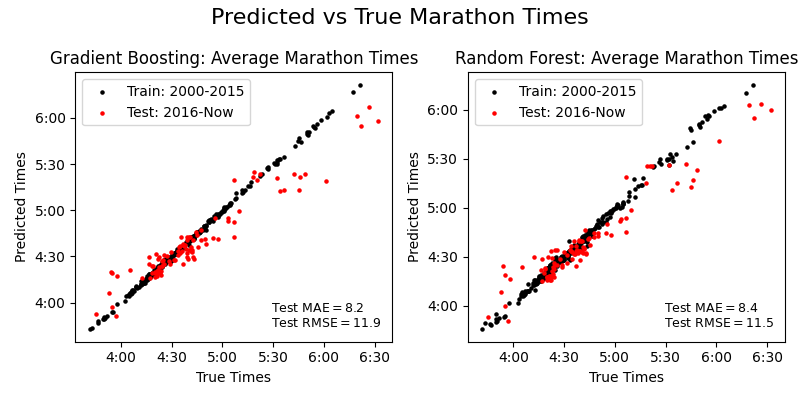

In [35]:
fig, axs = plt.subplots(1,2,figsize=(8,4))
(ax1,ax2) = axs

y_ave_test_gb = grid_gb_shuffle_ave.predict(X_ave_test)
y_ave_train_gb = grid_gb_shuffle_ave.predict(X_ave_train)

ax1.scatter(y_ave_train,y_ave_train_gb,color='k', s=5, label='Train: 2000-2015')
ax1.scatter(y_ave_test,y_ave_test_gb,color='r', s=5, label='Test: 2016-Now')
ax1.set_xlabel('True Times')
ax1.set_ylabel('Predicted Times')
ax1.set_title('Gradient Boosting: Average Marathon Times')

grid_rf_shuffle_ave
y_ave_test_rf = grid_rf_shuffle_ave.predict(X_ave_test)
y_ave_train_rf = grid_rf_shuffle_ave.predict(X_ave_train)

ax2.scatter(y_ave_train,y_ave_train_rf,color='k', s=5, label='Train: 2000-2015')
ax2.scatter(y_ave_test,y_ave_test_rf,color='r', s=5, label='Test: 2016-Now')
ax2.set_xlabel('True Times')
ax2.set_ylabel('Predicted Times')
ax2.set_title('Random Forest: Average Marathon Times')

# Set tick labels and legends
for ax in [ax1,ax2]:
    ax.yaxis.set_major_locator(mticker.MultipleLocator(base=1800))
    ax.yaxis.set_major_formatter(formatter)
    ax.xaxis.set_major_locator(mticker.MultipleLocator(base=1800))
    ax.xaxis.set_major_formatter(formatter)
    ax.legend()

# Create annotations for fit metrics
gb_note = AnchoredText(f"Test MAE$={ave_perf_df.loc['GB Ave','Test MAE']:.1f}$\nTest RMSE$={ave_perf_df.loc['GB Ave','Test RMSE']:.1f}$",
                     prop=dict(size=9), frameon=False, loc='lower right')
rf_note = AnchoredText(f"Test MAE$={ave_perf_df.loc['RF Ave','Test MAE']:.1f}$\nTest RMSE$={ave_perf_df.loc['RF Ave','Test RMSE']:.1f}$",
                     prop=dict(size=9), frameon=False, loc='lower right')
ax1.add_artist(gb_note)
ax2.add_artist(rf_note)

fig.suptitle('Predicted vs True Marathon Times', fontsize=16)

fig.tight_layout()

In [36]:
# Honolulu has all of the slowest averages because the course stays open for walking participants.
# Test data (recent years) has 4 of the 5 slowest overall average finish times.
# full_df.sort_values('Average Time', ascending=False).iloc[:20,:12]

### Not used: Tree Ensembles with Time-Series Cross-validation ###

In [37]:
# Training split uses time-series cross validation
from sklearn.model_selection import TimeSeriesSplit

ts_cv = TimeSeriesSplit(n_splits=5)
all_splits = list(ts_cv.split(X_ave_train, y_ave_train))
train_0, test_0 = all_splits[0]
train_4, test_4 = all_splits[-1]
# X_ave_train.iloc[test_0]
print(len(train_0))
print(len(test_0))
print(len(train_4))
print(len(test_4))

54
50
254
50


In [38]:
# Gradient Boosting Tree Ensembles: Grid Search with Time Series cross-validator
from sklearn.model_selection import GridSearchCV
# Training split uses time-series cross validation
from sklearn.model_selection import TimeSeriesSplit

ts_cv = TimeSeriesSplit(n_splits=5, max_train_size=50)
grid_values = {'max_depth': [1, 2, 3, 4],
               'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2],
               'n_estimators': [50, 100, 150, 200, 250]}

gb_cv_ave = GradientBoostingRegressor(random_state=0)
grid_gb_ave = GridSearchCV(gb_cv_ave, param_grid = grid_values, cv=ts_cv)
grid_gb_ave.fit(X_ave_train, y_ave_train)

print(f'Best Paramters (squared error): {grid_gb_ave.best_params_}')
print(f'Best Score (R^2): {grid_gb_ave.best_score_}')
print(f'Test Set Score (R^2): {grid_gb_ave.score(X_ave_test, y_ave_test)}')

Best Paramters (squared error): {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 250}
Best Score (R^2): 0.9049604776085655
Test Set Score (R^2): 0.8725139194984939


In [39]:
# max_train_size=None:
# Best Paramters (squared error): {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 250}
# Best Score (R^2): 0.9135540160845889
# Test Set Score (R^2): 0.8725139194984939

# max_train_size=100:
# Best Paramters (squared error): {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 250}
# Best Score (R^2): 0.909646140631061
# Test Set Score (R^2): 0.8725139194984939

# max_train_size=50:
# Best Paramters (squared error): {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 250}
# Best Score (R^2): 0.9049604776085655
# Test Set Score (R^2): 0.8725139194984939

In [40]:
print(grid_gb_ave.cv_results_.keys())
print(len(grid_gb_ave.cv_results_['param_learning_rate']))
pd.DataFrame(grid_gb_ave.cv_results_).iloc[-5:]

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_learning_rate', 'param_max_depth', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])
100


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
95,0.017607,0.000173,0.001237,0.000054,0.2,4,50,"{'learning_rate': 0.2, 'max_depth': 4, 'n_esti...",0.697259,0.842950,0.844992,0.844550,0.885945,0.823139,0.064990,54
96,0.033550,0.000349,0.001294,0.000033,0.2,4,100,"{'learning_rate': 0.2, 'max_depth': 4, 'n_esti...",0.697038,0.842998,0.844981,0.844571,0.885968,0.823111,0.065084,55
97,0.050145,0.000241,0.001371,0.000019,0.2,4,150,"{'learning_rate': 0.2, 'max_depth': 4, 'n_esti...",0.697038,0.842998,0.844980,0.844570,0.885967,0.823111,0.065084,56
98,0.066436,0.000923,0.001513,0.000131,0.2,4,200,"{'learning_rate': 0.2, 'max_depth': 4, 'n_esti...",0.697038,0.842998,0.844980,0.844570,0.885967,0.823111,0.065084,58
99,0.080887,0.000096,0.001473,0.000061,0.2,4,250,"{'learning_rate': 0.2, 'max_depth': 4, 'n_esti...",0.697038,0.842998,0.844980,0.844570,0.885967,0.823111,0.065084,57


### To Implement: ###
__Gradient Boosting and Random Forest__
1. Test larger n_estimators
2. Try to unpack grid_gb_ave.cv_results_ in pandas to plot parameter trends
3. Fit and plot the female and male data sets with grid search
4. Plot residuals vs true time, color code by event

__Linear Regression Models__
1. Make plots for average, female, and male
2. Plot residuals vs true time, color code by event

__General Trends__
1. Train model using all data and plot trends of varying one feature while setting others to median value
2. Create df of R2, RMSE, and MAE values